In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

from torchvision import models, transforms
from torch.utils.data import *
import numpy as np

from torch import nn
import math

import torch.nn.functional as F
import os
import glob
from natsort import natsorted
import copy

from torch.utils.checkpoint import checkpoint

from tqdm import tqdm
from torchvision.utils import save_image
from torch.optim import Adam, AdamW

C:\Users\fed97\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Impossibile trovare la procedura specificata'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)
print()

# Clear cache
torch.cuda.empty_cache()

#Additional Info when using cuda
if device.type == 'cuda':
    print('Device:', torch.cuda.get_device_name(0))
    print('Allocated:', torch.cuda.memory_allocated(0)/1024**3, 'GB')
    print('Cached:   ', torch.cuda.memory_reserved(0)/1024**3, 'GB')

Using device: cuda

Device: NVIDIA GeForce RTX 3060 Ti
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
class Textures(Dataset):
    def __init__(self,
                 dataPath = "Dataset",
                 image_size = 64,
                 image_condition_size = 32,
                 trainingTargets = ["bricks"]
        ):
        super(Dataset, self).__init__()

        self.path = [dataPath + "/"+ target + "/unzipped" for target in trainingTargets]
        self.data = [os.listdir(path) for path in self.path]
        self.trainingTargets = trainingTargets
        self.transforms = transforms  
        self.image_size = image_size
        self.image_condition_size = image_condition_size

        #filter out the directories
        self.data = [(f"{self.path[index]}/{image}/*_Color.jpg", index) for index, dirs in enumerate(self.data) for image in dirs if glob.glob(os.path.join(self.path[index], image + "/*_Color.jpg")) ]
        
    
    
    
    def __len__(self):
        return len(self.data)
    


    def __getitem__(self, idx):
        """
        train: the image that is used to train the generator
        image: the full image of train
        """
        path, label = self.data[idx]

        img = Image.open(glob.glob(path)[0])
        
        transformBase = transforms.Compose([
                        transforms.Resize(self.image_size),
                        #transforms.RandomHorizontalFlip()
                    ])
        
        img = transformBase(img)

        tranformsCondition = transforms.Compose([
            transforms.CenterCrop(self.image_condition_size),
            transforms.Resize(self.image_size, interpolation=Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        imgCondition = tranformsCondition(img) 
            
        transformsFull = transforms.Compose([
                        transforms.CenterCrop(self.image_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
        
        
        
        imgFull = transformsFull(img)

        
        return imgFull, imgCondition, label 



In [4]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)


def get_data(args):
    dataset = Textures(dataPath=args.dataset_path, image_size=args.image_size, image_condition_size=args.image_condition_size, trainingTargets=args.dataset_name)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader


def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

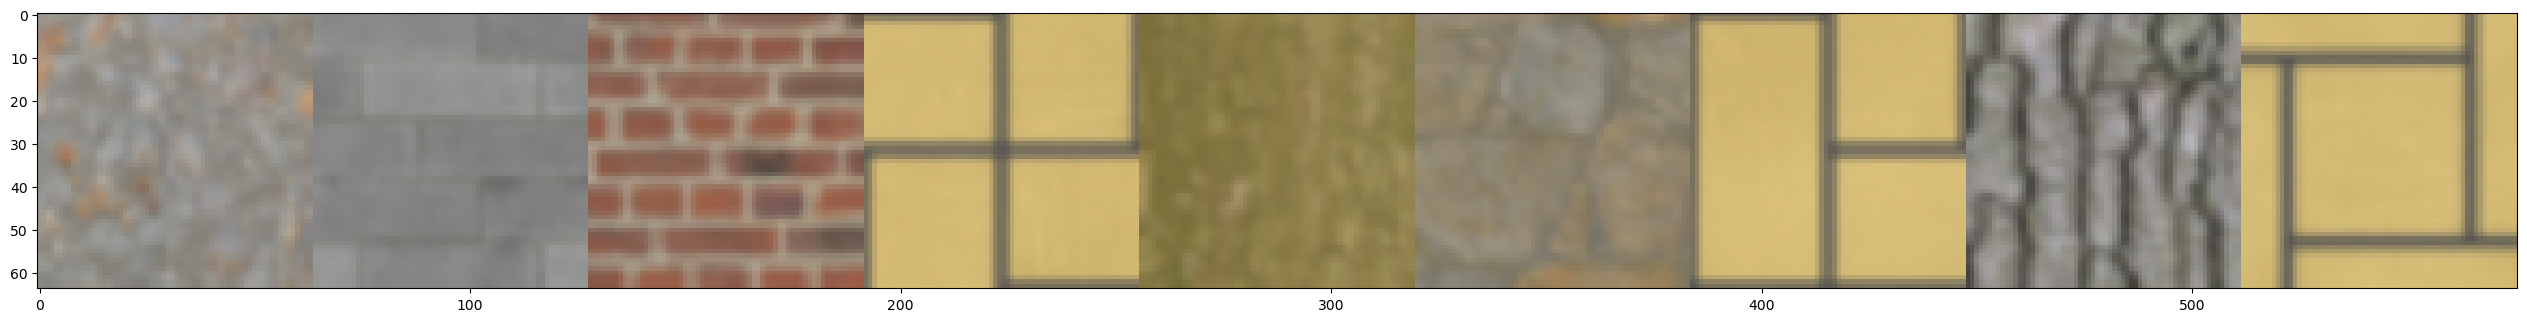

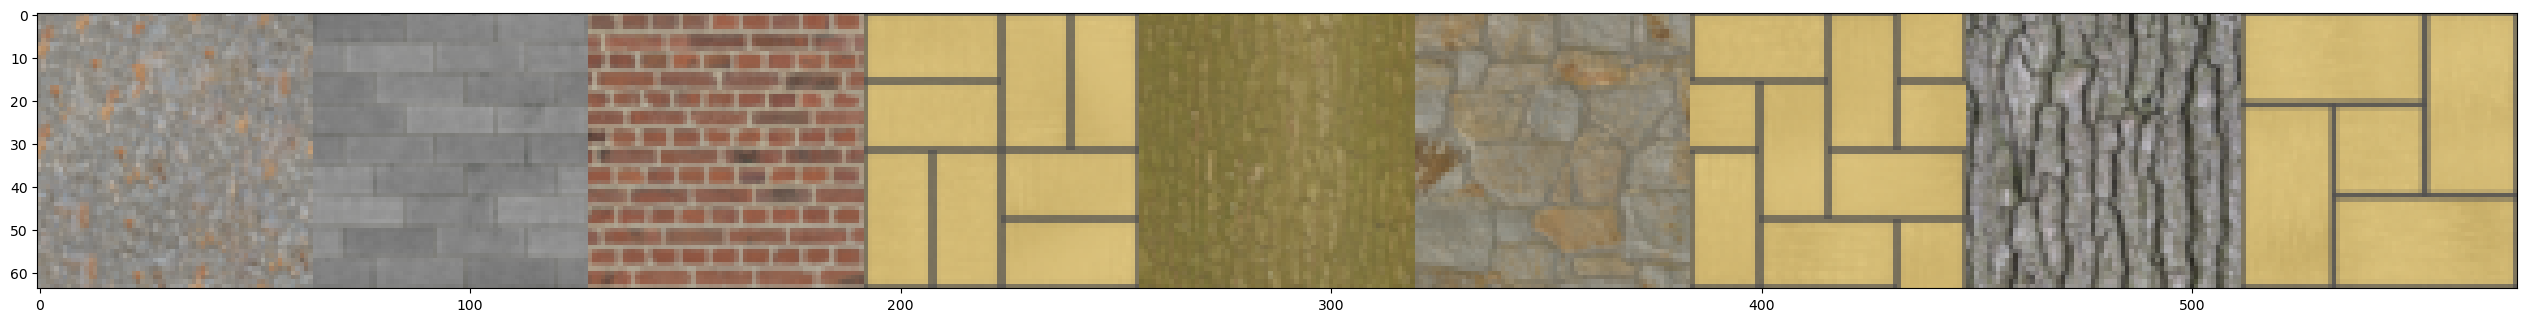

In [5]:
def convertPic(x):
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

dataset = Textures(dataPath="Dataset", image_size=64, image_condition_size=32, trainingTargets = ["tatami", "bricks", "bark"])
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

img1 = []
img2 = []
for a,b,_ in dataloader:    
    img1.append(convertPic(b))
    img2.append(convertPic(a))

plot_images(torch.cat(img1))
plot_images(torch.cat(img2))

save_images(torch.cat(img2), os.path.join("results", "test", f"groundtruth.jpg"))



In [6]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )
        
    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)
    


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)

        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1]) 
        return x + emb
    


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    

class UNet_conditional(nn.Module):   
    def __init__(self, c_in=6, c_out=3, time_dim=256, img_size=64, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, img_size//2) #(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, img_size//4) #(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, img_size//8) #(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, img_size//4) #(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, img_size//2) #(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, img_size) #(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
            

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)  
        
            
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output


In [7]:
def testSample(num_classes, device, model, ema_model, diffusion, image_condition_size, run_name="test", epoch="test"):
    labels = torch.arange(num_classes).long().to(device)

    images_1 = [Image.open("Dataset/tatami/unzipped/Tatami005_2K-JPG/Tatami005_2K-JPG_Color.jpg"), Image.open("Dataset/bricks/unzipped/Bricks066_2K-JPG/Bricks066_2K-JPG_Color.jpg"), Image.open("Dataset/bark/unzipped/Bark006_2K-JPG/Bark006_2K-JPG_Color.jpg")]        
    images_2 = [Image.open("Dataset/tatami/unzipped/Tatami006_2K-JPG/Tatami006_2K-JPG_Color.jpg"), Image.open("Dataset/bricks/unzipped/Bricks075A_2K-JPG/Bricks075A_2K-JPG_Color.jpg"), Image.open("Dataset/bark/unzipped/Bark008_2K-JPG/Bark008_2K-JPG_Color.jpg")]        
    images_3 = [Image.open("Dataset/tatami/unzipped/Tatami004_2K-JPG/Tatami004_2K-JPG_Color.jpg"), Image.open("Dataset/bricks/unzipped/Bricks085_2K-JPG/Bricks085_2K-JPG_Color.jpg"), Image.open("Dataset/bark/unzipped/Bark001_2K-JPG/Bark001_2K-JPG_Color.jpg")]        

    sampled_images_cond_1, condition_images_1, real_images_1 = diffusion.sample(model, n=num_classes, conditions=images_1, labels=labels, image_condition_size=image_condition_size)
    ema_sampled_images_cond_1, _, _ = diffusion.sample(ema_model, n=num_classes, conditions=images_1, labels=labels, image_condition_size=image_condition_size)     

    sampled_images_cond_2, condition_images_2, real_images_2 = diffusion.sample(model, n=num_classes, conditions=images_2, labels=labels, image_condition_size=image_condition_size)
    ema_sampled_images_cond_2, _, _ = diffusion.sample(ema_model, n=num_classes, conditions=images_2, labels=labels, image_condition_size=image_condition_size)  
            
    sampled_images_cond_3, condition_images_3, real_images_3 = diffusion.sample(model, n=num_classes, conditions=images_3, labels=labels, image_condition_size=image_condition_size)
    ema_sampled_images_cond_3, _, _ = diffusion.sample(ema_model, n=num_classes, conditions=images_3, labels=labels, image_condition_size=image_condition_size)  

    print("Conditioning images:")
    plot_images(condition_images_1)
    print("Real images:")
    plot_images(real_images_1)
    print("Generated image conditioned:")
    plot_images(sampled_images_cond_1)
    plot_images(ema_sampled_images_cond_1)
            
    print("Conditioning images 2:")
    plot_images(condition_images_2)
    print("Real images:")
    plot_images(real_images_2)
    print("Generated image conditioned 2:")
    plot_images(sampled_images_cond_2)
    plot_images(ema_sampled_images_cond_2)      
            
    print("Conditioning images 3:")
    plot_images(condition_images_3)
    print("Real images:")
    plot_images(real_images_3)
    print("Generated image conditioned 3:")
    plot_images(sampled_images_cond_3)
    plot_images(ema_sampled_images_cond_3)

    save_images(condition_images_1, os.path.join("results", run_name, f"{epoch}_conditioner_1.jpg"))
    save_images(sampled_images_cond_1, os.path.join("results", run_name, f"{epoch}_1.jpg"))
    save_images(ema_sampled_images_cond_1, os.path.join("results", run_name, f"{epoch}_ema_1.jpg"))
    save_images(real_images_1, os.path.join("results", run_name, f"{epoch}_real_1.jpg"))
            
    save_images(condition_images_2, os.path.join("results", run_name, f"{epoch}_conditioner_2.jpg"))
    save_images(sampled_images_cond_2, os.path.join("results", run_name, f"{epoch}_2.jpg"))
    save_images(ema_sampled_images_cond_2, os.path.join("results", run_name, f"{epoch}_ema_2.jpg"))
    save_images(real_images_2, os.path.join("results", run_name, f"{epoch}_real_2.jpg"))
            
    save_images(condition_images_3, os.path.join("results", run_name, f"{epoch}_conditioner_3.jpg"))
    save_images(sampled_images_cond_3, os.path.join("results", run_name, f"{epoch}_3.jpg"))
    save_images(ema_sampled_images_cond_3, os.path.join("results", run_name, f"{epoch}_ema_3.jpg"))
    save_images(real_images_3, os.path.join("results", run_name, f"{epoch}_real_3.jpg"))
    
    return torch.cat((ema_sampled_images_cond_1, ema_sampled_images_cond_2, ema_sampled_images_cond_3), dim=0), torch.cat((condition_images_1, condition_images_2, condition_images_3), dim=0), torch.cat((real_images_1, real_images_2, real_images_3), dim=0)
    #return torch.cat((sampled_images_cond_1, sampled_images_cond_2, sampled_images_cond_3), dim=0), torch.cat((condition_images_1, condition_images_2, condition_images_3), dim=0), torch.cat((real_images_1, real_images_2, real_images_3), dim=0)

In [8]:
import logging
from torch.utils.tensorboard import SummaryWriter

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=300, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))    
        
    def preprocess_conditions(self, conditions, image_condition_size):   
        transformsCondition = transforms.Compose([
                        transforms.Resize(self.img_size),
                        #transforms.RandomHorizontalFlip(),
                        transforms.CenterCrop(image_condition_size),
                        transforms.Resize(self.img_size, interpolation=Image.BILINEAR),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

                    ])
        
        transformsReal = transforms.Compose([
                        transforms.Resize(self.img_size),
                        transforms.CenterCrop(self.img_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
        
        images = torch.stack([transformsCondition(image) for image in conditions])
        real_images = torch.stack([transformsReal(image) for image in conditions])

            
        return images.to(self.device), real_images.to(self.device)

    def sample(self, model, n, conditions, labels, cfg_scale=3, image_condition_size=32, img_size=None):
        logging.info(f"Sampling {n} new images....")
        output_class = None
        if img_size is None:
            img_size = self.img_size
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, img_size, img_size)).to(self.device)

            real_images = None
            if conditions is not None:
                conditions, real_images = self.preprocess_conditions(conditions, image_condition_size)  

            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                inputImg = torch.cat([x,conditions],1).to(self.device)
                
                predicted_noise = model(inputImg, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        if conditions is not None:
            conditions = (conditions.clamp(-1, 1) + 1) / 2
            conditions = (conditions * 255).type(torch.uint8)
            real_images = (real_images.clamp(-1, 1) + 1) / 2
            real_images = (real_images * 255).type(torch.uint8)
        return x, conditions, real_images


def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = UNet_conditional(num_classes=args.num_classes, img_size=args.image_size).to(device)
    optimizer = AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    
    epochCheckpoint = 0
    if args.loadWeights and glob.glob("models/modelWeights.pth.tar"):
        checkpoint = torch.load("models/modelWeights.pth.tar", map_location="cuda" if torch.cuda.is_available() else "cpu")
        model.load_state_dict(checkpoint["model"], strict=False)
        ema_model.load_state_dict(checkpoint["ema_model"], strict=False)
        optimizer.load_state_dict(checkpoint["optimizer"])
        epochCheckpoint = checkpoint["epoch"]
    
    logging.info(f"Starting epoch {epochCheckpoint}:")
    ebar = tqdm(range(epochCheckpoint, args.epochs), initial=epochCheckpoint, total=args.epochs)

    for epoch in ebar:
        pbar = dataloader
        for i, (images, conditions, labels) in enumerate(pbar):
            images = images.to(device)
            conditions = conditions.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(torch.cat([x_t,conditions],1), t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

        ebar.set_postfix(MSE=loss.item())    
        if (epoch+1) % 50 == 0 and args.saveWeights:
            checkpoint = {
                "model": model.state_dict(),
                "ema_model": ema_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint, "models/modelWeights.pth.tar")           
            
        if (epoch+1) % 2000 == 0:            
            
            checkpoint = {
                "model": model.state_dict(),
                "ema_model": ema_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint, f"models/modelWeightsBackup.pth.tar") 
            
            _, _, _ = testSample(args.num_classes, device, model, ema_model, diffusion, args.image_condition_size, args.run_name, epoch)


In [9]:
from torch.autograd import Variable
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

def mae(input, target):
    with torch.no_grad():
        loss = nn.L1Loss()
        output = loss(input, target)
    return output


def inception_score(imgs, cuda=True, batch_size=3, resize=True, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    transf = transforms.Compose([
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
        
    imgs = torch.stack([transf(image) for image in imgs.float()])
        
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [10]:
def test(args):
    device = args.device
    dataloader = get_data(args)
    model = UNet_conditional(num_classes=args.num_classes, img_size=args.image_size).to(device)
    optimizer = AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)
    
    if args.loadWeights and glob.glob("models/modelWeights.pth.tar"):
        checkpoint = torch.load("models/modelWeights.pth.tar", map_location="cuda" if torch.cuda.is_available() else "cpu")
        model.load_state_dict(checkpoint["model"], strict=False)
        ema_model.load_state_dict(checkpoint["ema_model"], strict=False)
        optimizer.load_state_dict(checkpoint["optimizer"])
        epochCheckpoint = checkpoint["epoch"]
        
    fake_images, conditions, real_images = testSample(args.num_classes, device, model, ema_model, diffusion, args.image_condition_size)
        
    from torchmetrics.image.fid import FrechetInceptionDistance
    fid = FrechetInceptionDistance(normalize=True).to(device)
    fid.update(real_images, real=True)
    fid.update(fake_images, real=False)
    print(f"FID: {float(fid.compute())}")
    
    print(f"IS: {inception_score(fake_images, splits=3)}")
    
    from torchmetrics.image import VisualInformationFidelity
    vif = VisualInformationFidelity().to(device)
    print(f"VIF: {vif(fake_images.float(), real_images.float())}")
        


In [11]:
class CustomArgs:
    def __init__(self):
        self.run_name = "DDPM_conditional"
        self.epochs = 150000
        self.batch_size = 5
        self.image_size = 64
        self.image_condition_size = 32
        self.dataset_path = "Dataset"
        self.dataset_name = ["tatami", "bricks", "bark"]
        self.num_classes = len(self.dataset_name)
        self.device = "cuda"
        self.lr = 3e-4
        self.loadWeights = True
        self.saveWeights = True        


def run(training=False, testing=False):
    args = CustomArgs()
    if training:
        train(args)
    if testing:
        test(args)
        


04:16:32 - INFO: Sampling 3 new images....
299it [00:09, 31.69it/s]
04:16:42 - INFO: Sampling 3 new images....
299it [00:08, 33.56it/s]
04:16:51 - INFO: Sampling 3 new images....
299it [00:09, 32.17it/s]
04:17:01 - INFO: Sampling 3 new images....
299it [00:09, 32.77it/s]
04:17:10 - INFO: Sampling 3 new images....
299it [00:09, 32.66it/s]
04:17:19 - INFO: Sampling 3 new images....
299it [00:08, 33.66it/s]


Conditioning images:


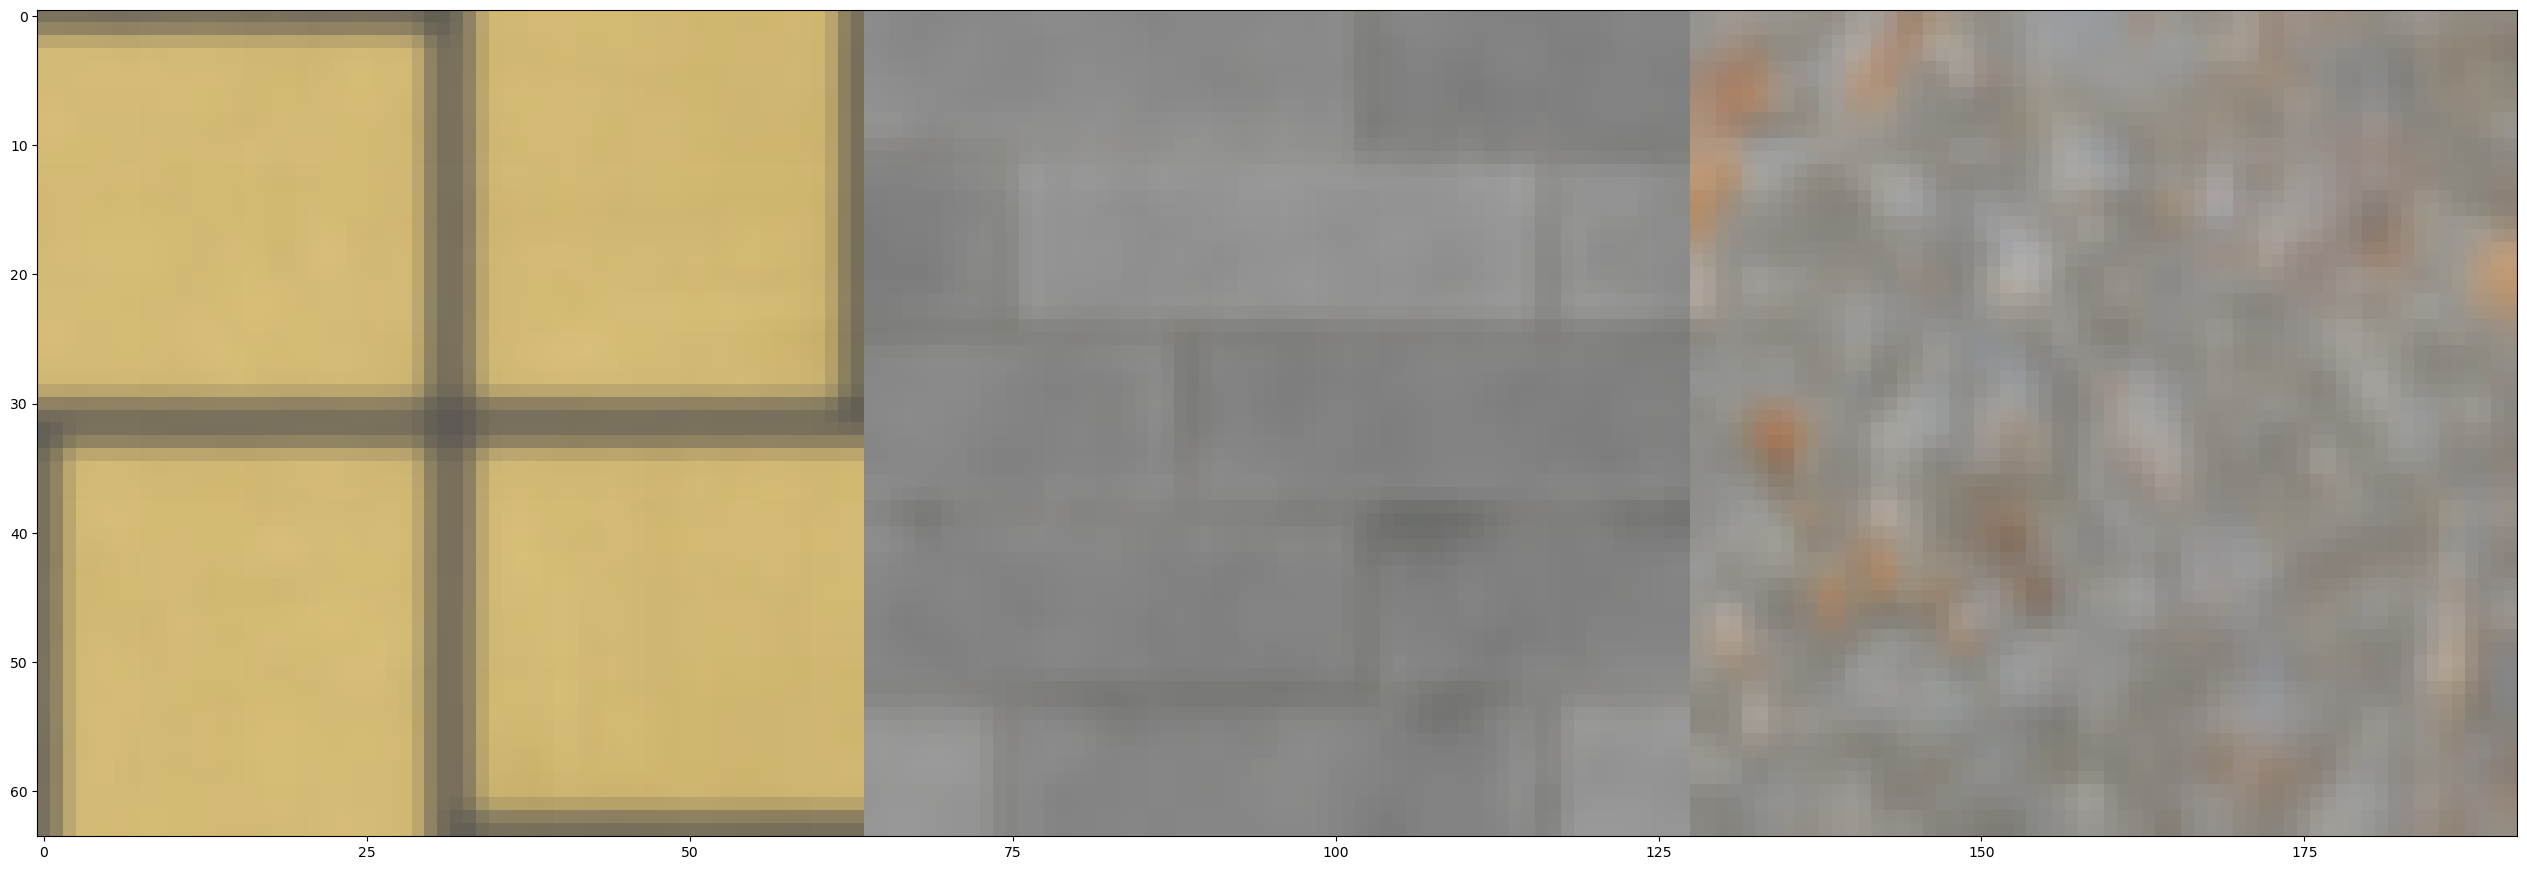

Real images:


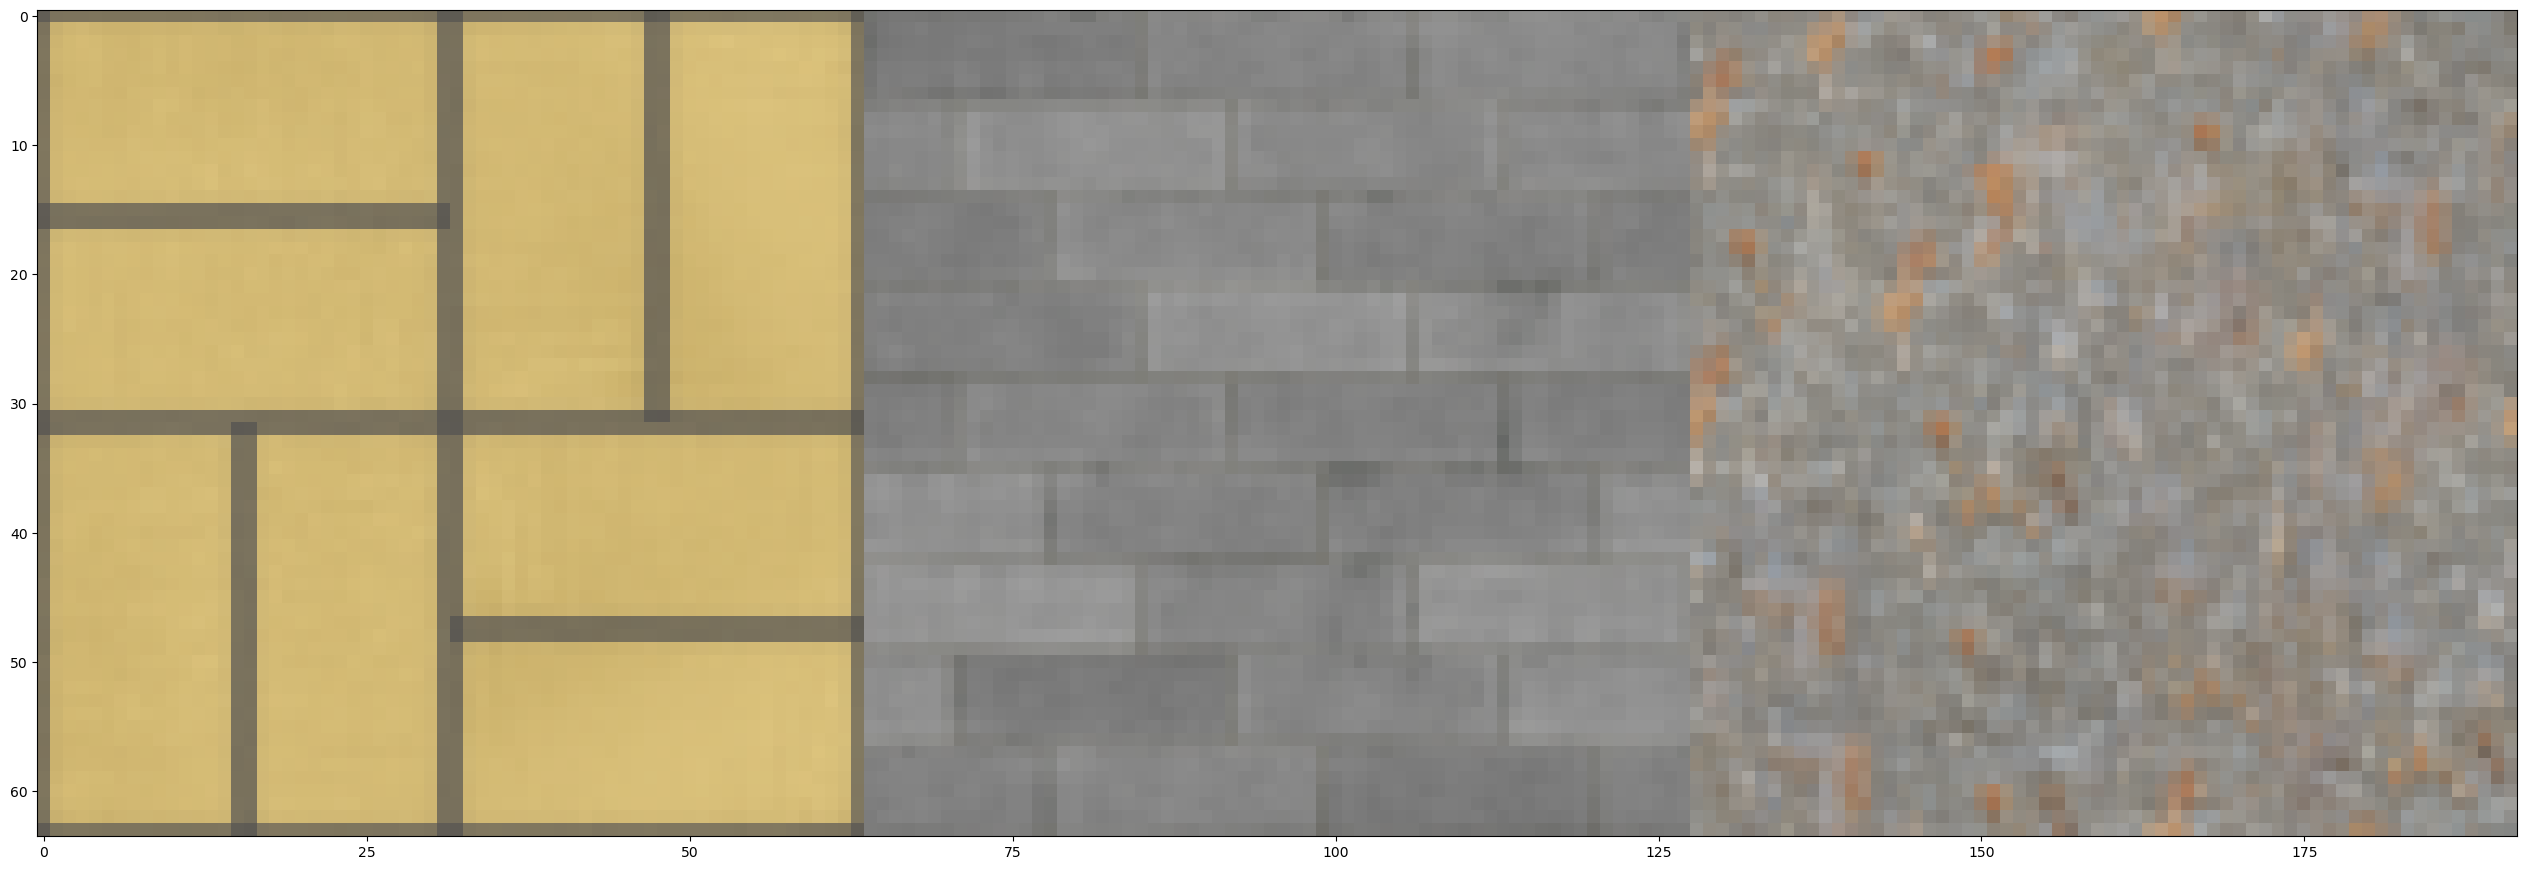

Generated image conditioned:


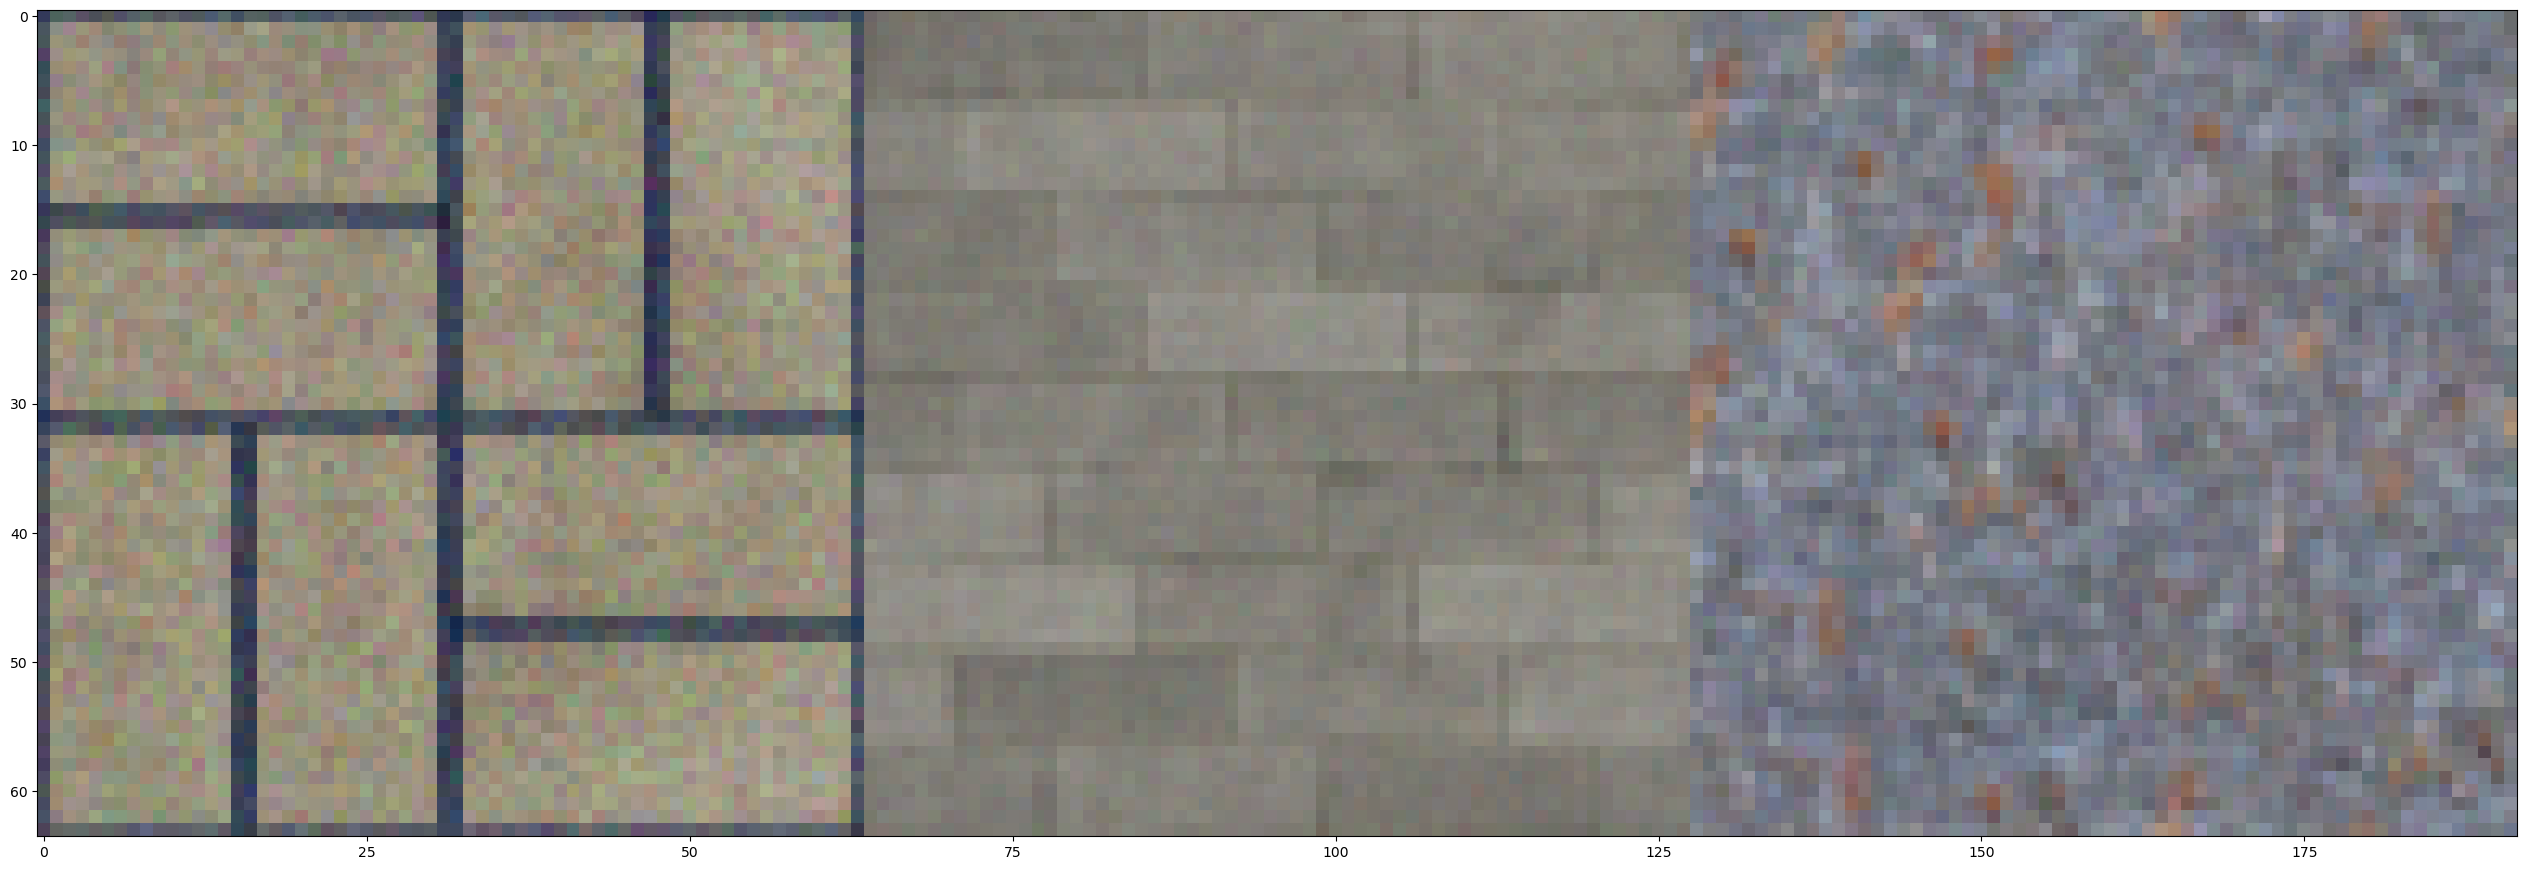

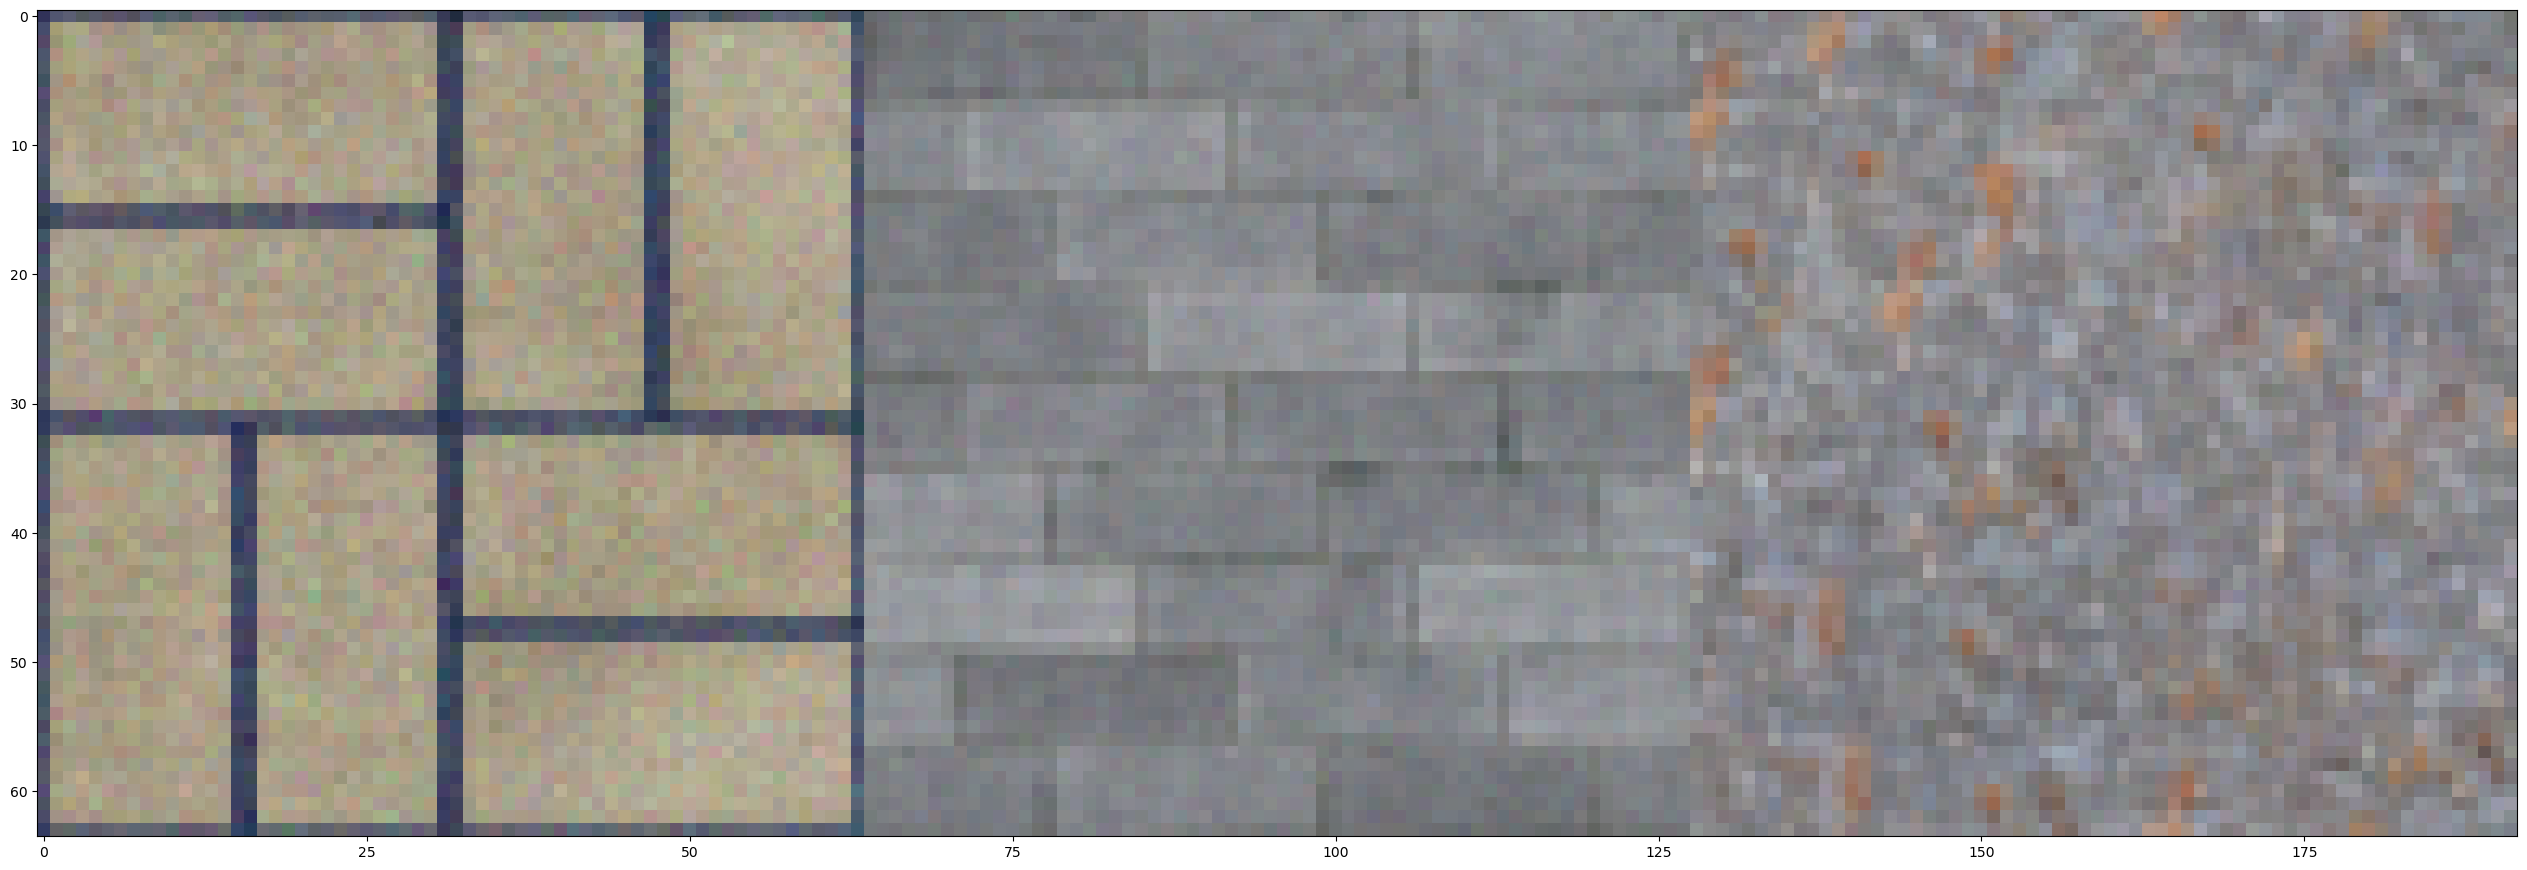

Conditioning images 2:


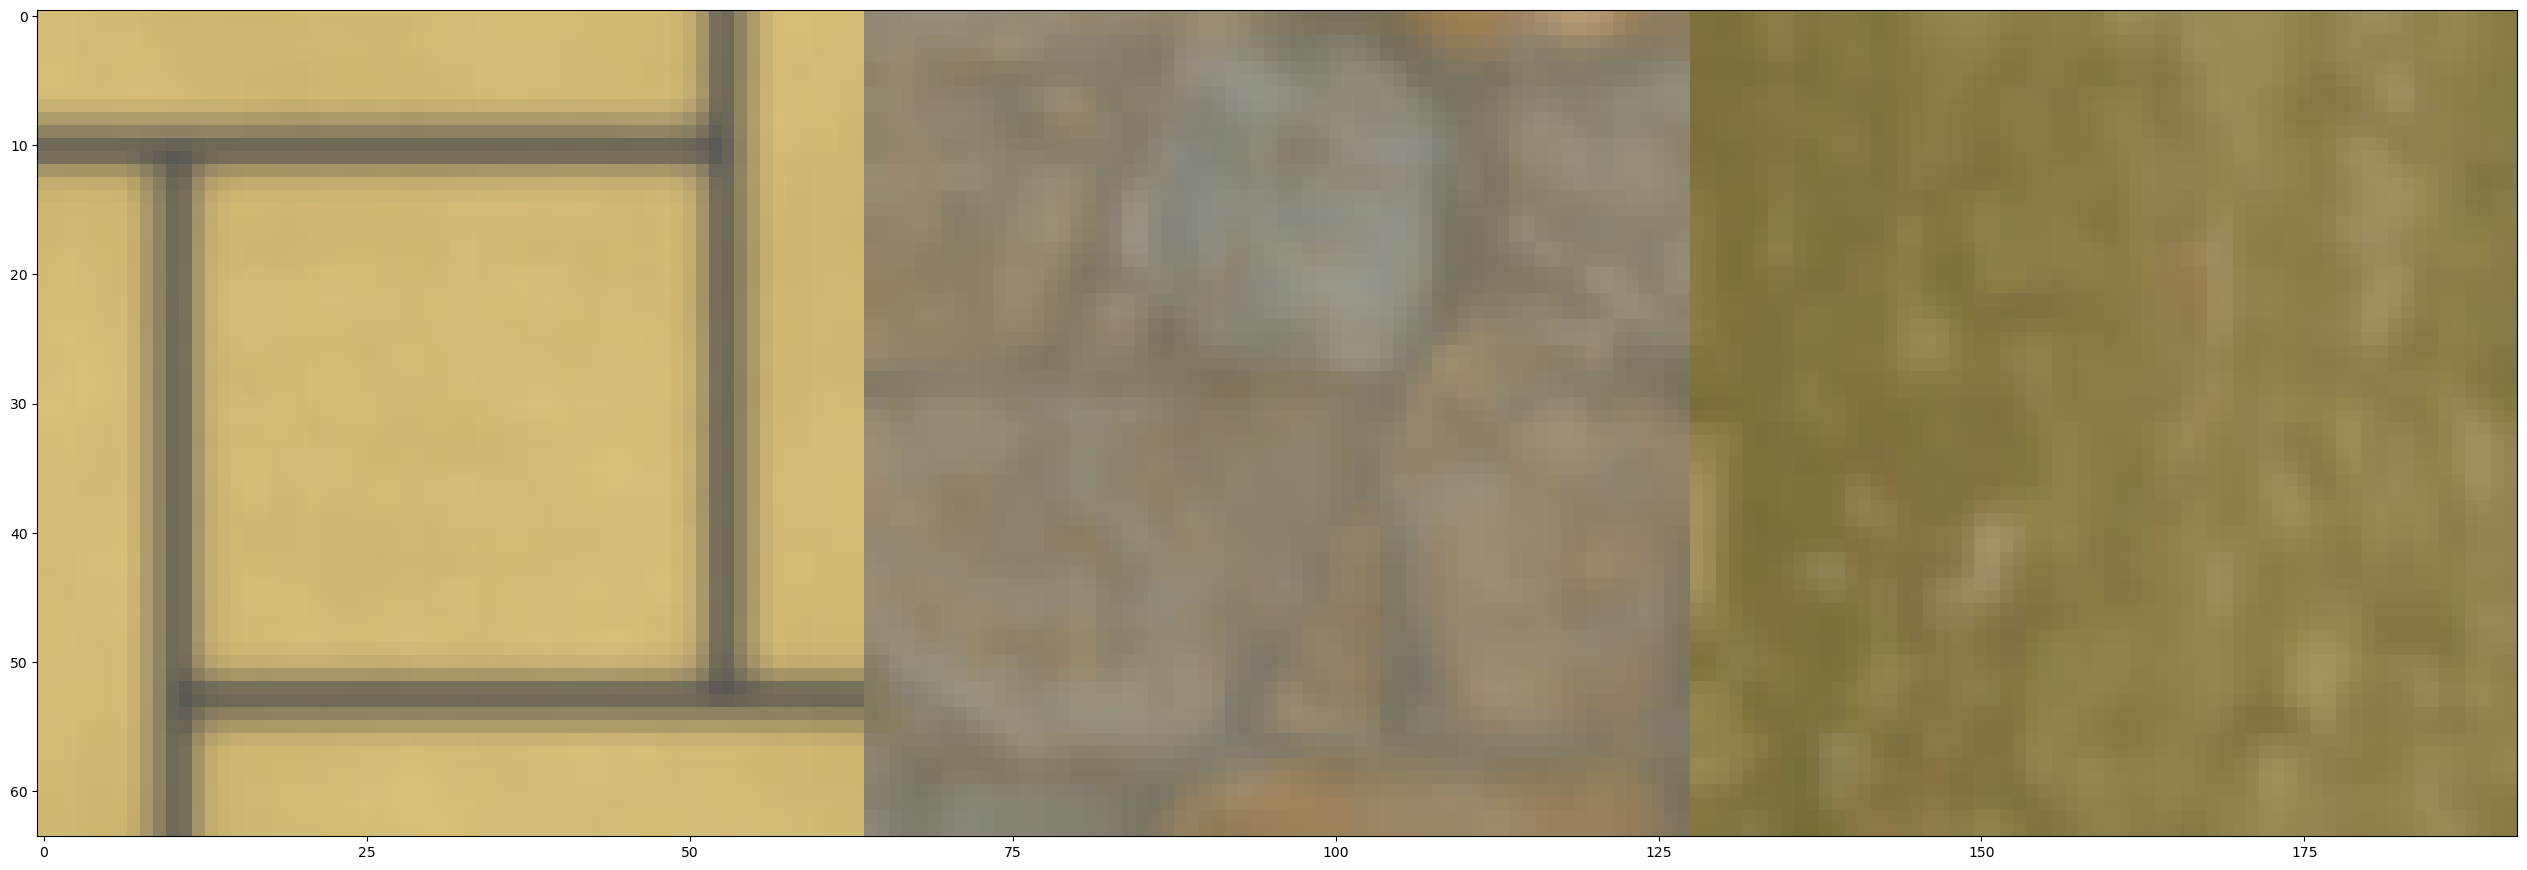

Real images:


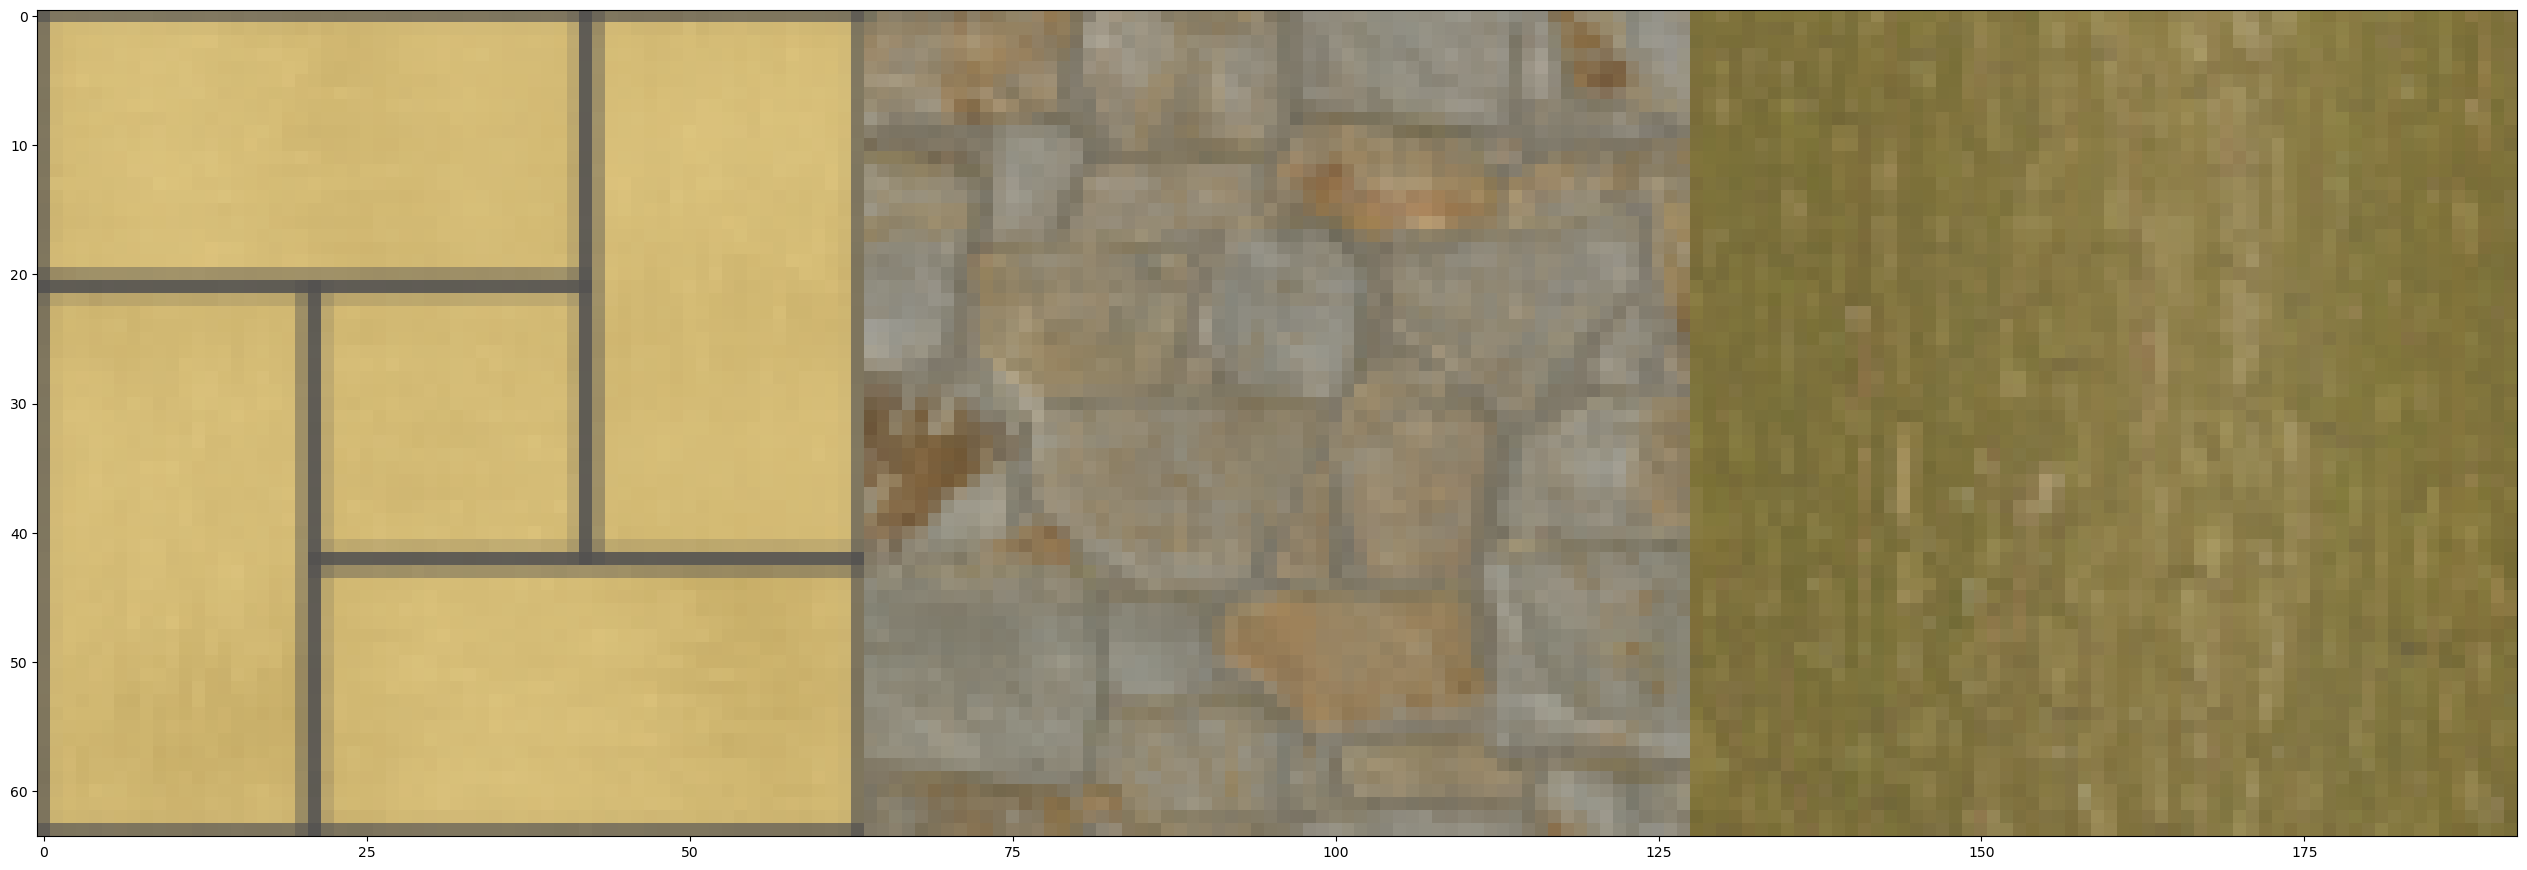

Generated image conditioned 2:


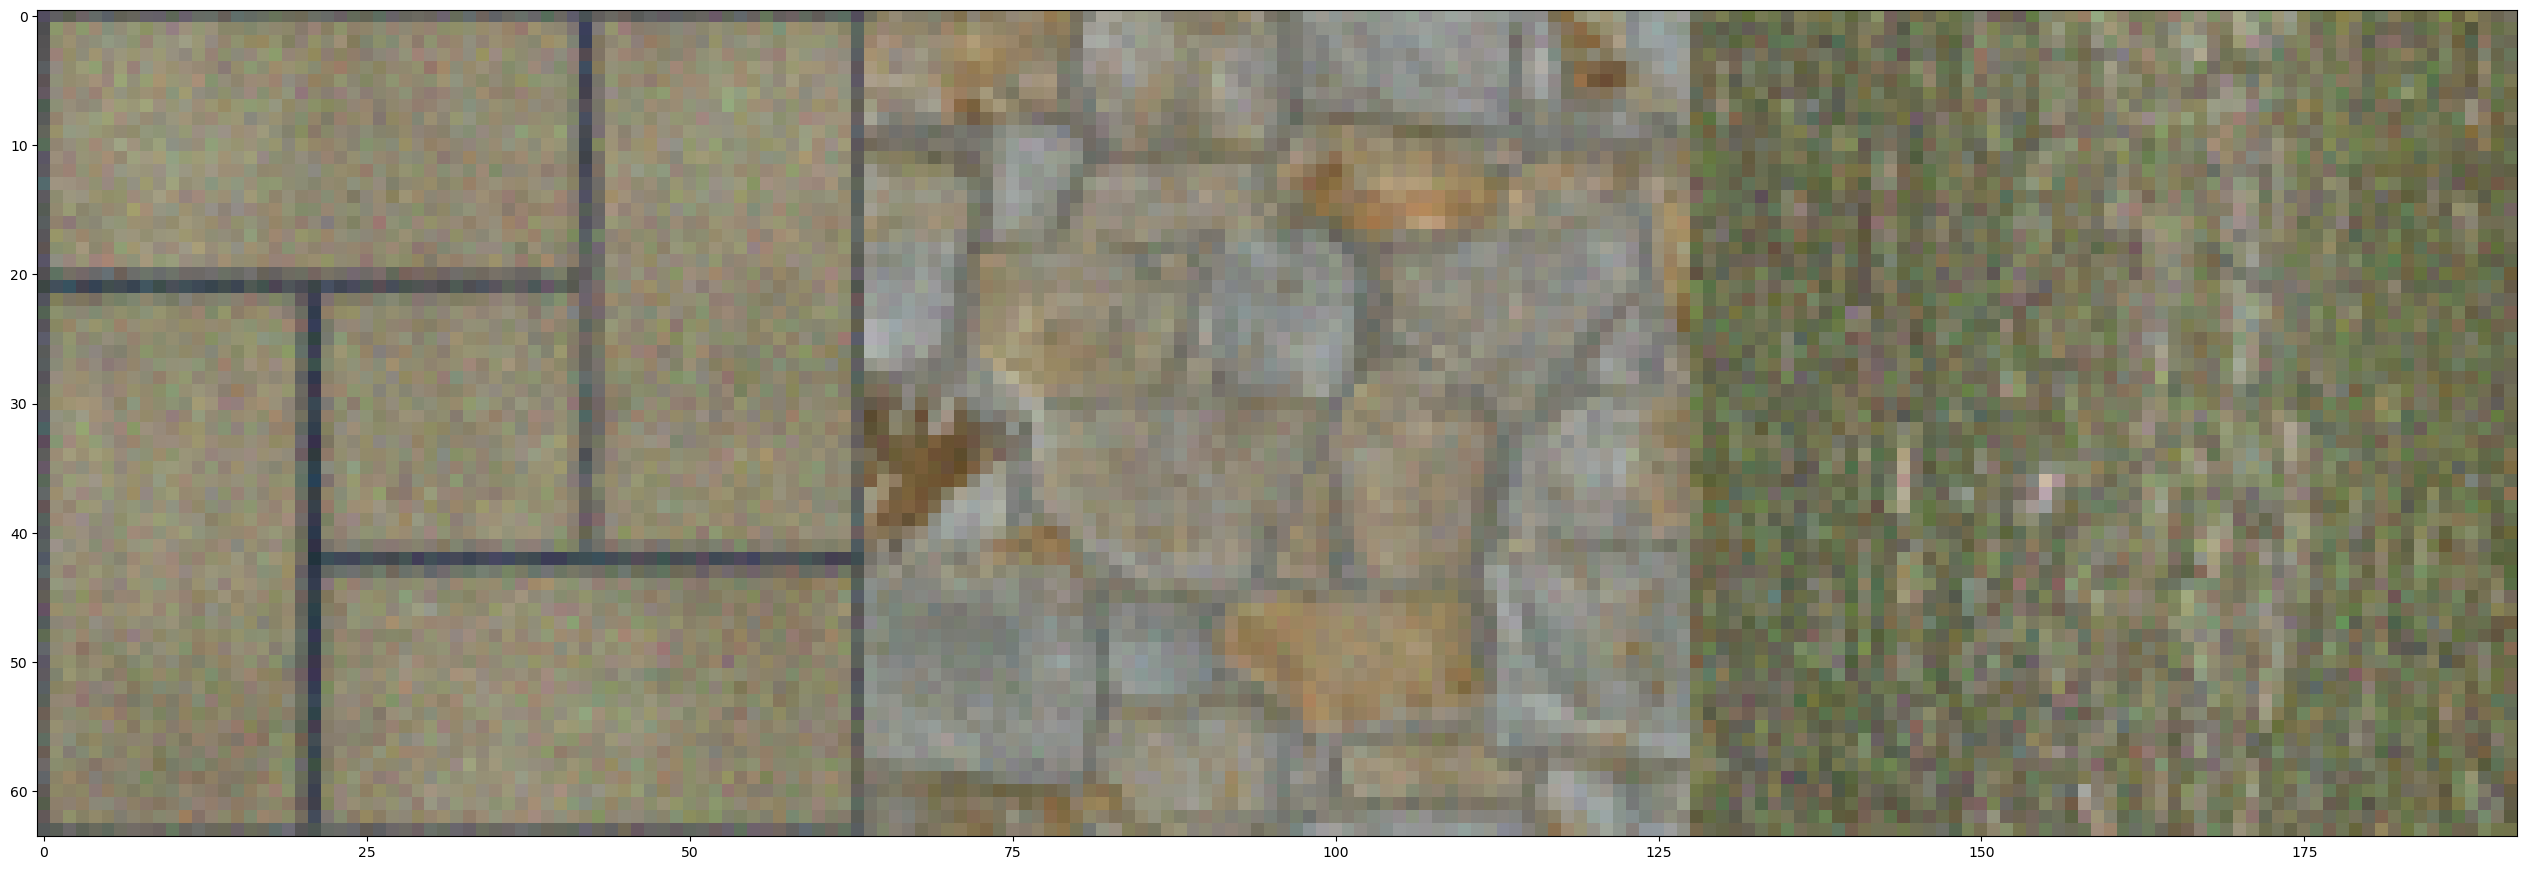

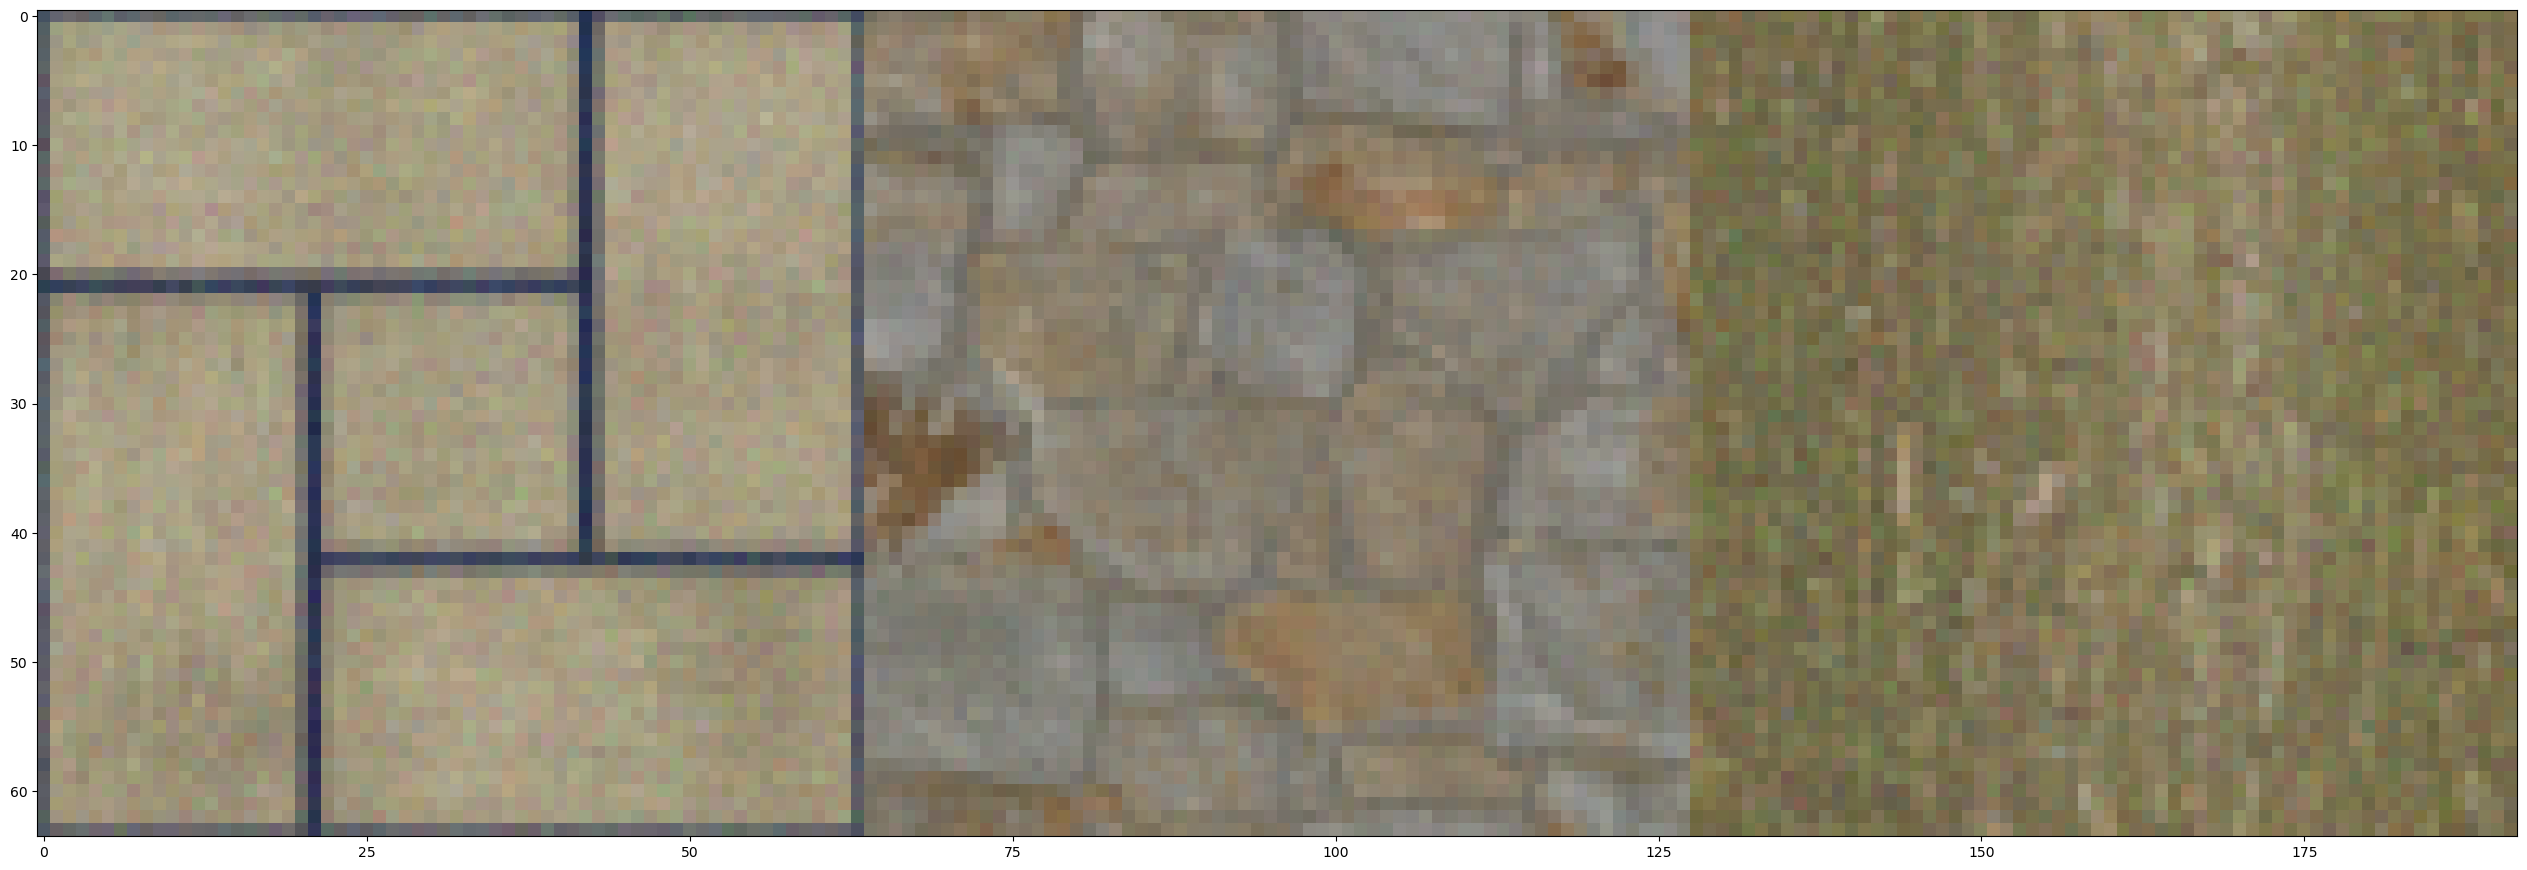

Conditioning images 3:


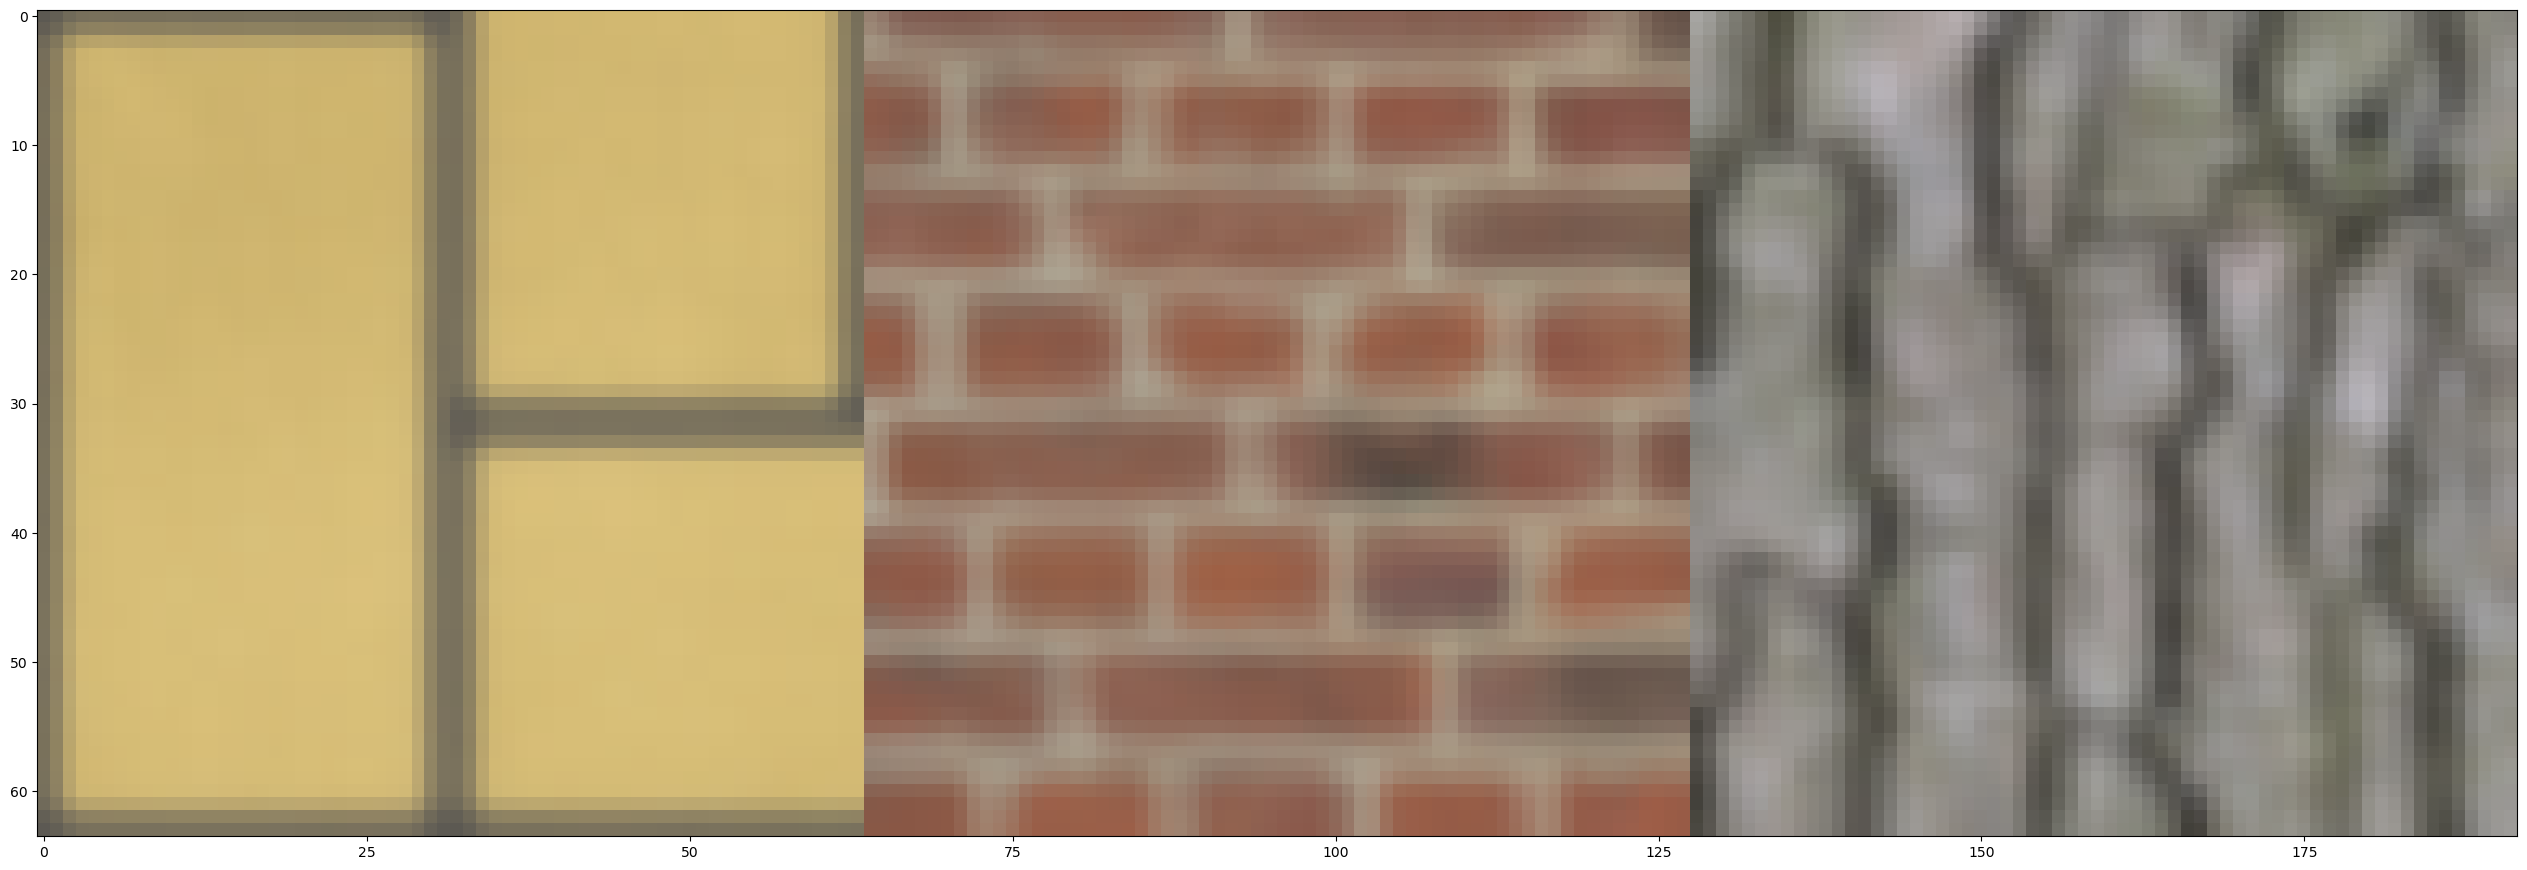

Real images:


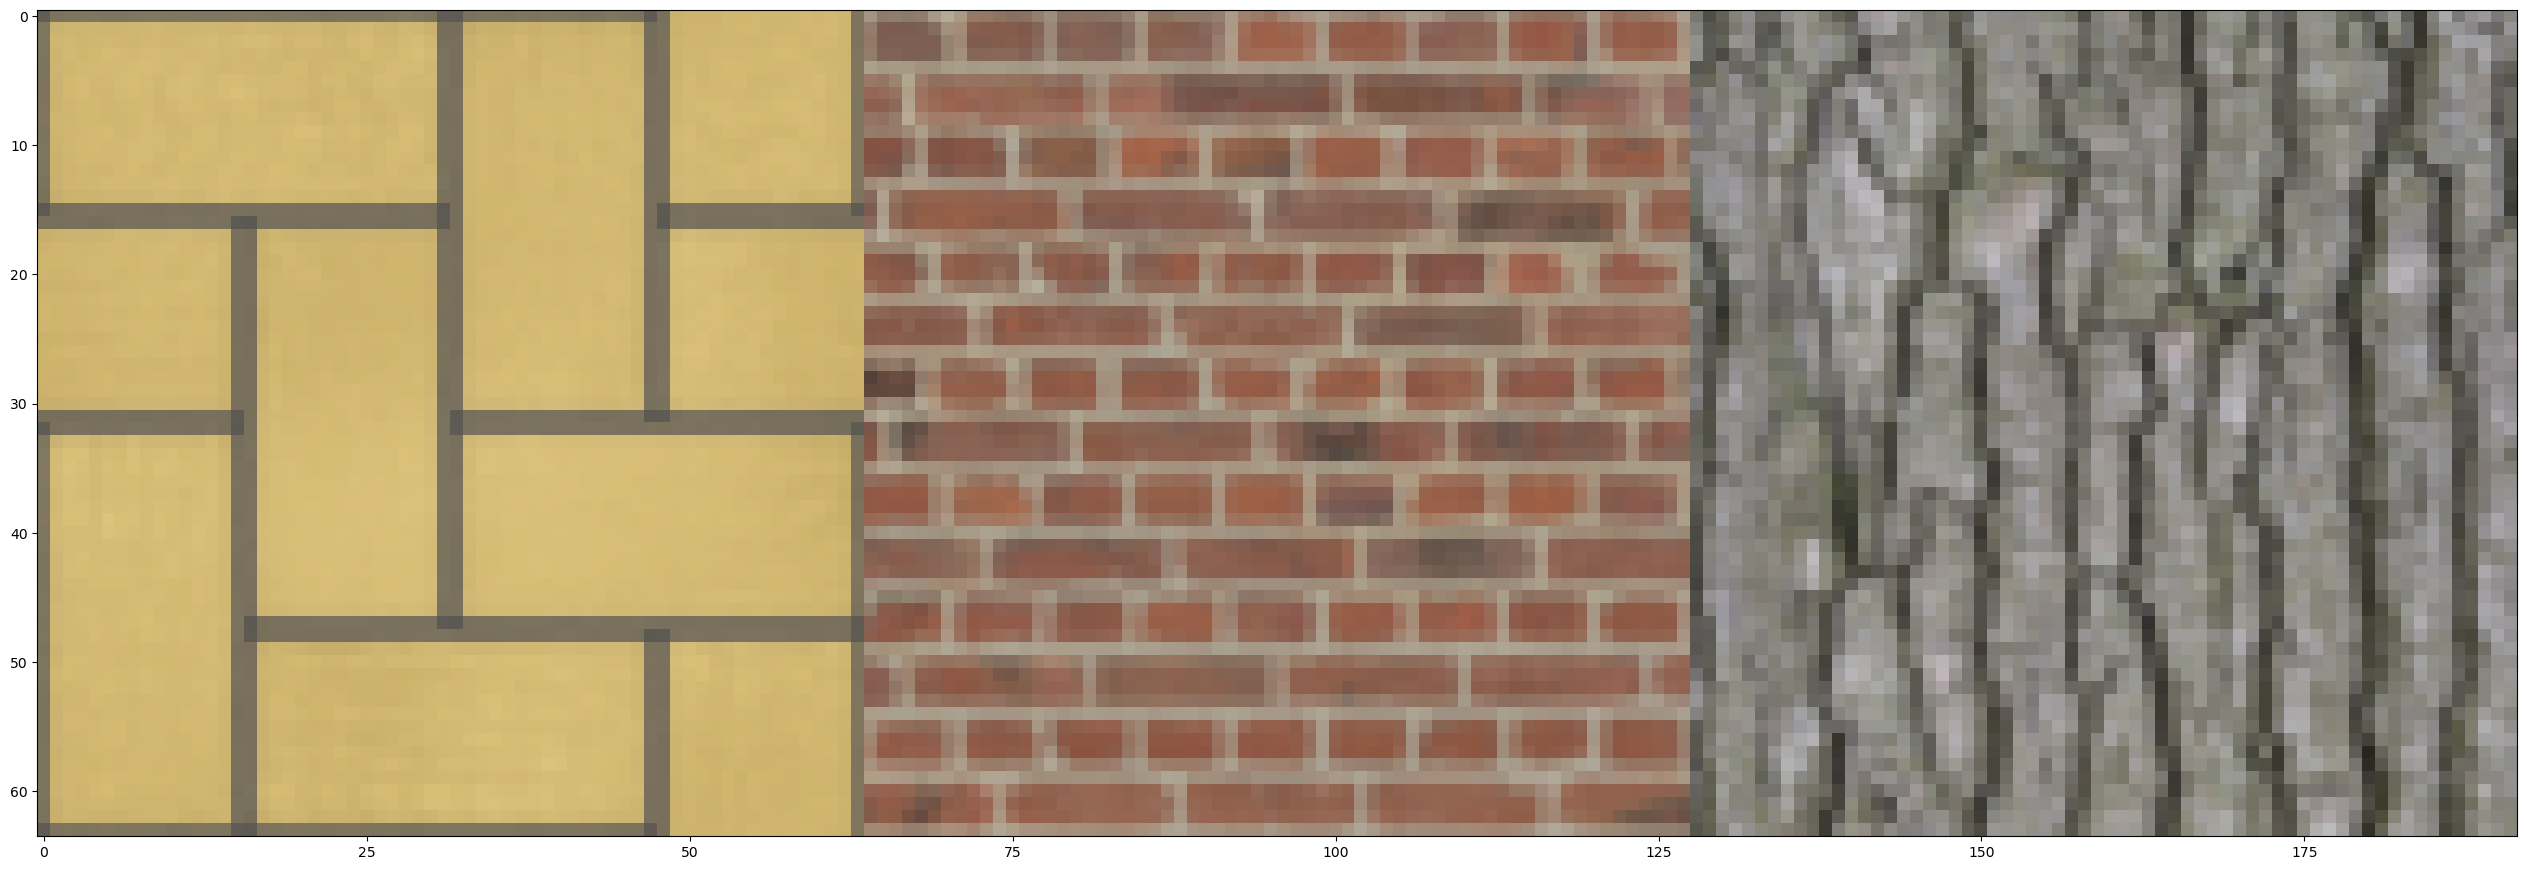

Generated image conditioned 3:


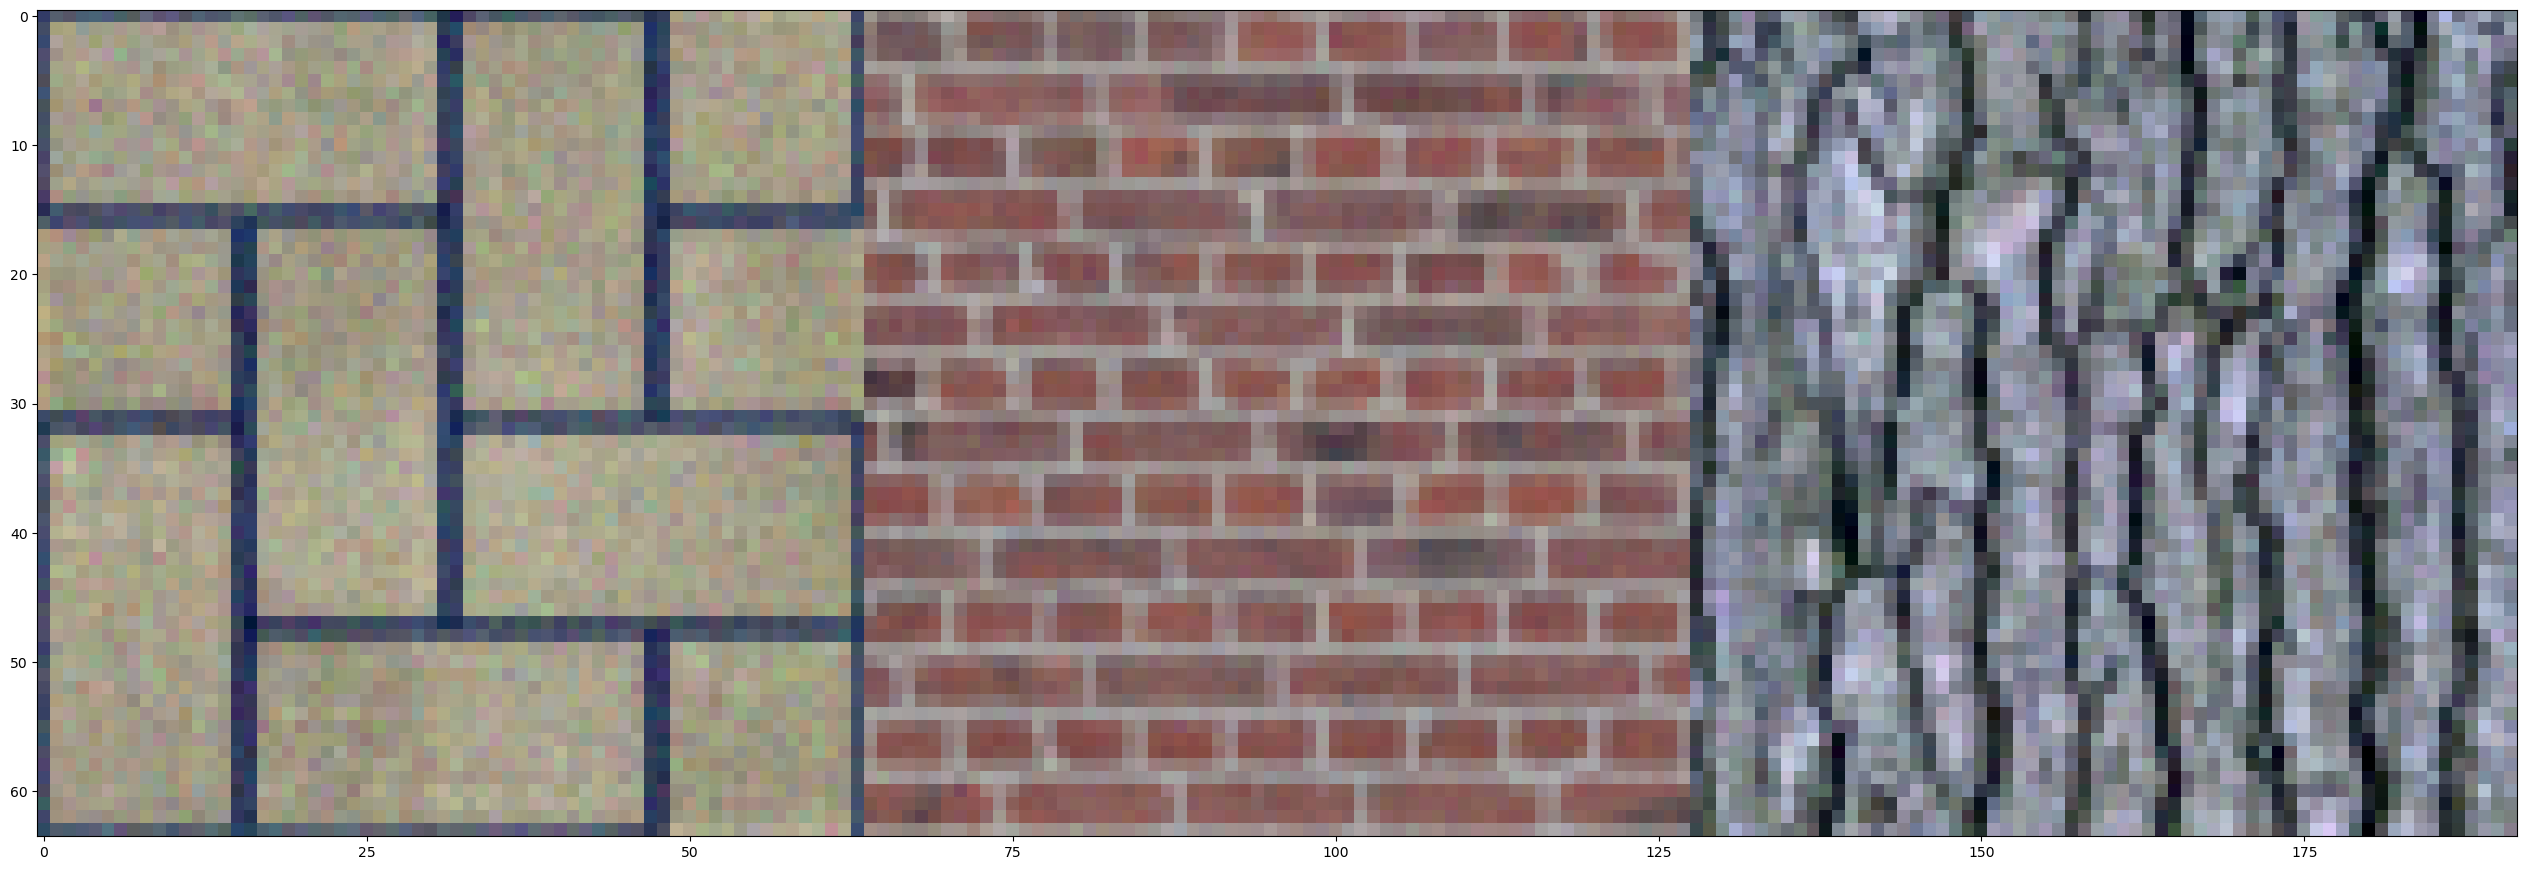

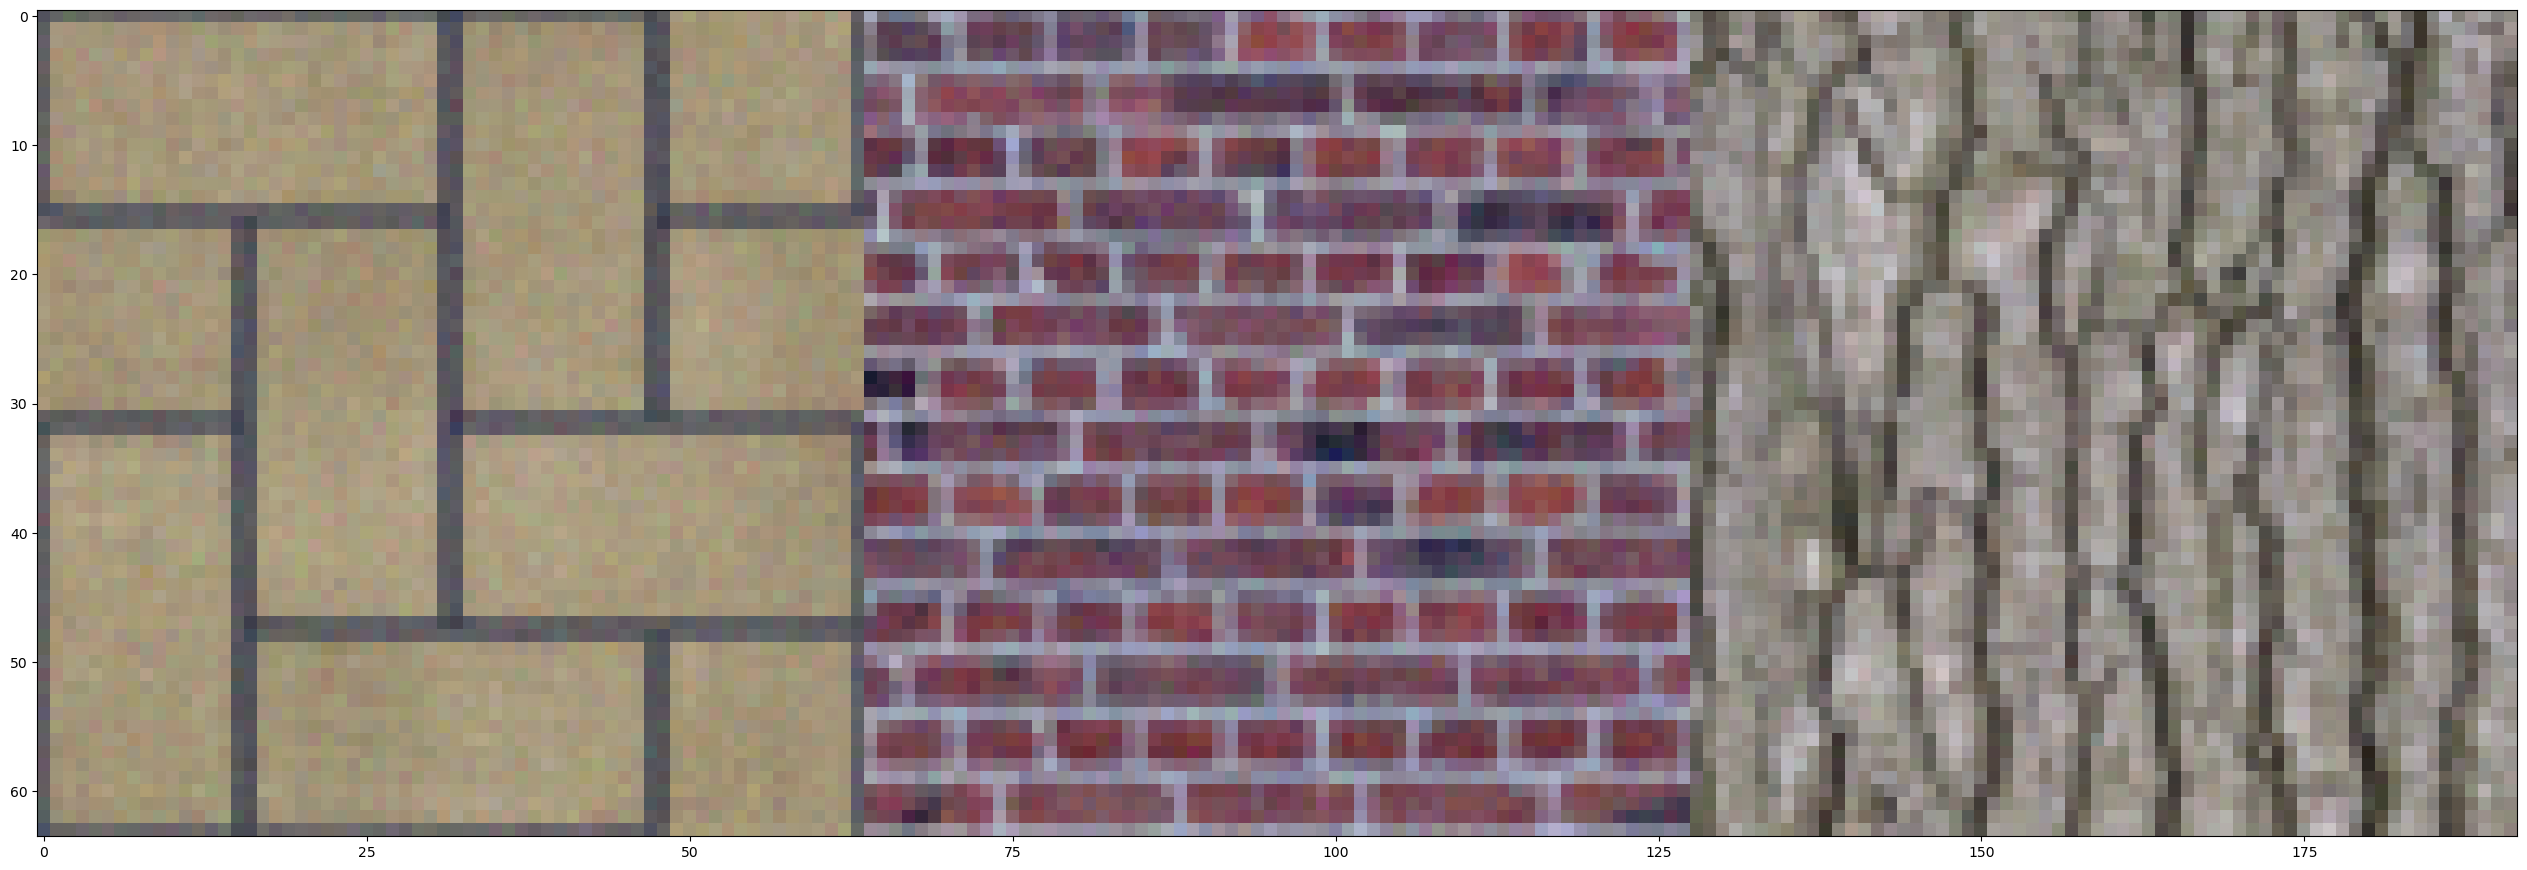

FID: 106.59117126464844


C:\Users\fed97\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


IS: (tensor(1., device='cuda:0'), tensor(3.6500e-08, device='cuda:0'))


C:\Users\fed97\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fed97\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


IS: (1.305989614064181, 0.4130097845808712)
VIF: 0.6225912570953369


C:\Users\fed97\AppData\Local\Temp\ipykernel_3196\2311741858.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


In [12]:
run(training=False, testing=True)